# Test PPO Agent
Bill Xia <br>
October 14, 2024

**Purpose:** To test our PPO agent by running it on various configurations of the EscGridEnv environment.

In [ ]:
# Imports.
import torch
from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper
from rl_models.PPO_Agent import PPO_Agent

from EscGridEnv.EscGridEnv import EscGridEnv
from EscGridEnv.levels import (
    lvl_1,
    lvl_1_rand,
    lvl_2,
    lvl_3,
    lvl_4,
    lvl_5,
    lvl_6,
    lvl_7,
    lvl_8,
    lvl_9,
    lvl_10,
    lvl_11,
    lvl_12,
    lvl_13a,
    lvl_13b
)

from tqdm import tqdm
import numpy as np

from json import dump

In [2]:
# Confirm that we have access to GPU.
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    print("No GPU available, using CPU.")

Using GPU: NVIDIA RTX A6000


## Initialize Model

In [3]:
# Load environment. A wrapper is needed for the PPO policy.
env = EscGridEnv(
    max_steps=500,
    grid_layout=lvl_1_rand(),
    use_rand_start=True,
    # rand_objs=['c', 'p']
    rand_objs=['g']
)
env = FullyObsWrapper(env)
env = ImgObsWrapper(env)

print(f'Action space: {env.action_space}')

Action space: Discrete(3)


In [4]:
# Load model.
agent = PPO_Agent(
    env,
    episodes=5e5,
    dev=device,
    verbose=0
)

In [ ]:
# Define name of the model we want to save/load.
model_name = 'models/ppo_newGamma_0'

## Train Model

In [6]:
# Train model.
agent.train()

In [7]:
# Only run this block if you just trained something.
agent.save_model(model_name)
agent.delete_model()

## Evaluation

In [8]:
agent.load_model(model_name)

In [ ]:
levels = [
    lvl_1, lvl_2, lvl_3, lvl_4, lvl_5, lvl_6, lvl_7,
    lvl_8, lvl_9, lvl_10, lvl_11, lvl_12, lvl_13a, lvl_13b,
    # crate_test, key_test
]

data = []
paths = {}

for func in levels:

    print(str(func))

    # Initialize evaluation environment.
    eval_env  = EscGridEnv(
        max_steps=500,
        grid_layout=func()
    )
    eval_env  = FullyObsWrapper(eval_env)
    eval_env  = ImgObsWrapper(eval_env)

    paths[str(func).split(' ')[1]] = []

    # We will run evaluation 100 times to collect aggregated performance data.
    succ, steps = [], []

    for _ in tqdm(range(100)):
        # Prepare for evaluation.
        obs, _     = eval_env.reset()
        done       = False
        truncated  = False
        curr_steps = 0

        curr_path = []

        # Evaluate.
        while not (done or truncated):
            action = agent.predict(obs)
            curr_path.append(action)
            obs, reward, done, truncated, _ = eval_env.step(action)
            curr_steps += 1
            if curr_steps >= 500:
                break

        paths[str(func).split(' ')[1]].append(curr_path)

        # print(f'Found goal: {done}')
        if done:
            succ.append(True)
        else:
            succ.append(False)

        steps.append(curr_steps)

    eval_env.close()

    # Analysis.
    good_steps = []
    for result, curr_steps in zip(succ, steps):
        if result:
            good_steps.append(steps)
    if good_steps != []:
        data.append((
            succ.count(True),
            round(np.mean(good_steps), 2),
            round(np.std(good_steps), 2)
        ))
    else:
        data.append((
            succ.count(True),
            None,
            None
        ))

    print(f'  Successes: {succ.count(True)}')

    print('--------------------')

with open('../data/rl_data/succ.json', 'w') as fp:
    dump(data, fp, indent=4)

<function lvl_1 at 0x78c270d05870>


100%|██████████| 100/100 [00:33<00:00,  2.96it/s]


  Successes: 68
--------------------
<function lvl_2 at 0x78c270d05990>


100%|██████████| 100/100 [00:56<00:00,  1.76it/s]


  Successes: 9
--------------------
<function lvl_3 at 0x78c270d05ab0>


100%|██████████| 100/100 [00:58<00:00,  1.71it/s]


  Successes: 0
--------------------
<function lvl_4 at 0x78c270d05bd0>


100%|██████████| 100/100 [00:59<00:00,  1.69it/s]


  Successes: 0
--------------------
<function lvl_5 at 0x78c270d05cf0>


 61%|██████    | 61/100 [00:24<00:15,  2.44it/s]


KeyboardInterrupt: 

In [ ]:
# Printing results.
report = [
     "| Config    | Succ Rate | Num Steps Avg | Num Steps Std |",
     "| --------- | --------- | ------------- | ------------- |",
    f"| `lvl_1`   | {data[0][0] * 0.01}      | {data[0][1]}        | {data[0][2]}         |",
    f"| `lvl_2`   | {data[1][0] * 0.01}      | {data[1][1]}        | {data[1][2]}         |",
    f"| `lvl_3`   | {data[2][0] * 0.01}      | {data[2][1]}        | {data[2][2]}         |",
    f"| `lvl_4`   | {data[3][0] * 0.01}      | {data[3][1]}        | {data[3][2]}         |",
    f"| `lvl_5`   | {data[4][0] * 0.01}      | {data[4][1]}        | {data[4][2]}         |",
    f"| `lvl_6`   | {data[5][0] * 0.01}      | {data[5][1]}        | {data[5][2]}         |",
    f"| `lvl_7`   | {data[6][0] * 0.01}      | {data[6][1]}        | {data[6][2]}         |",
    f"| `lvl_8`   | {data[7][0] * 0.01}      | {data[7][1]}        | {data[7][2]}         |",
    f"| `lvl_9`   | {data[8][0] * 0.01}      | {data[8][1]}        | {data[8][2]}         |",
    f"| `lvl_10`  | {data[9][0] * 0.01}      | {data[9][1]}        | {data[9][2]}         |",
    f"| `lvl_11`  | {data[10][0] * 0.01}       | {data[10][1]}          | {data[10][2]}          |",
    f"| `lvl_12`  | {data[11][0] * 0.01}       | {data[11][1]}          | {data[11][2]}          |",
    f"| `lvl_13a` | {data[12][0] * 0.01}       | {data[12][1]}          | {data[12][2]}          |",
    f"| `lvl_13b` | {data[13][0] * 0.01}       | {data[13][1]}          | {data[13][2]}          |",
    # f"| `crate`   | {data[14][0] * 0.01}      | {data[14][1]}        | {data[14][2]}         |",
    # f"| `key`     | {data[15][0] * 0.01}      | {data[15][1]}        | {data[15][2]}         |",
]

print('\n'.join(report))
print()
print('Success Rate')
print(f'- **Avg:** {round(np.mean([info[0] for info in data]) / 100.0, 4)}')
print(f'- **Std:** {round(np.std([info[0] for info in data]) / 100.0, 4)}')

| Config    | Succ Rate | Num Steps Avg | Num Steps Std |
| --------- | --------- | ------------- | ------------- |
| `lvl_1`   | 0.04      | 491.36        | 46.48         |
| `lvl_2`   | 0.03      | 496.37        | 21.25         |
| `lvl_3`   | 0.0      | None        | None         |
| `lvl_4`   | 0.02      | 492.97        | 49.31         |
| `lvl_5`   | 0.0      | None        | None         |
| `lvl_6`   | 0.11      | 480.42        | 63.56         |
| `lvl_7`   | 0.0      | None        | None         |
| `lvl_8`   | 0.02      | 496.09        | 31.95         |
| `lvl_9`   | 0.02      | 493.7        | 45.32         |
| `lvl_10`  | 0.0      | None        | None         |
| `lvl_11`  | 0.0       | None          | None          |
| `lvl_12`  | 0.0       | None          | None          |
| `lvl_13a` | 0.0       | None          | None          |
| `lvl_13b` | 0.0       | None          | None          |

Success Rate
- **Avg:** 0.0171
- **Std:** 0.0289


## Visualization

In [ ]:
# Initialize visualization environment.
# vis_env  = EscGridEnv(
#     max_steps=500,
#     grid_layout=lvl_1_rand(),
#     use_rand_start=True,
#     rand_objs=['g'],
#     highlight=False         # Highlights agent's viewbox.
# )
vis_env  = EscGridEnv(
    max_steps=500,
    grid_layout=lvl_2(),
    use_rand_start=True,
    # rand_objs=['g'],
    highlight=False         # Highlights agent's viewbox.
)
vis_env  = FullyObsWrapper(vis_env)
vis_env  = ImgObsWrapper(vis_env)
vis_env.unwrapped.render_mode = 'rgb_array'

# Prepare to run the model.
obs, _     = vis_env.reset()
done       = False
truncated  = False
state_imgs = []
this_step  = 0

while not (done or truncated):

    # Capturing state renderings.
    state_imgs.append(vis_env.unwrapped.render())

    action = agent.predict(obs)
    obs, reward, done, truncated, _ = vis_env.step(action)

    this_step += 1
    if this_step % 100 == 99:
        print(f'Step: {this_step}')
    if this_step >= 500:
        break

# Capture final frame.
state_imgs.append(vis_env.unwrapped.render())

Step: 99
Step: 199
Step: 299
Step: 399
Step: 499


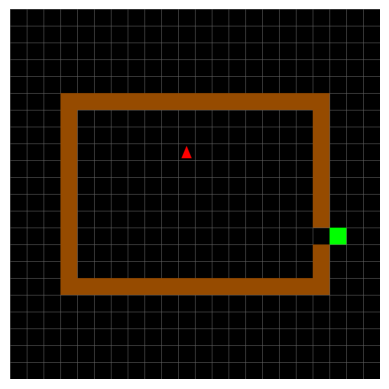

In [ ]:
# Imports.
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def display_video(frames, interval=50):
    fig, ax = plt.subplots()
    img = ax.imshow(frames[0])

    def update(frame):
        img.set_data(frame)
        return [img]

    ani = FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)

    plt.axis('off')  # Hide axes for a cleaner look

    # Use HTML to display the animation in Jupyter Notebook
    return HTML(ani.to_jshtml())

display_video(state_imgs)

In [ ]:
paths_revised = {
    lvl : [
        [int(pp) for pp in p] for p in ps
    ] for lvl, ps in paths.items()
}

with open('../data/rl_data/paths.json', 'w') as fp:
    dump(paths_revised, fp, indent=4)